todo:
- Tapering function
- Einheiten
- Glass Insertion
- Best FWHM wedge position?
- Filter Response
- Resampling of measured data
- scipy.fft.next_fast_len
- phase unwrap values outside 2pi
- wedges not straight
- Glass insertion offset as training parameter
- exclude zero frequency from arrays
- Smoothing of response function
- correct labels on plots
- left and right margin 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import scipy.special as math
from scipy import fft
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import pandas as pd
#import glob
#from tqdm import tqdm
#import multiprocessing as mp
#import os

plt.rcParams["figure.figsize"] = (8,6)
#np.set_printoptions(precision=5, suppress=True)

# electron volt
eV = 1.602176634e-19 # J
# reduced planck constant
h_bar = 1.054571817e-34   # J*s
# pulse duration [s] FWHM -- what I should get after the FT
T0  = 10e-15
# speed of light 
c = 299792458 # [m/s]
# bandwidth [rad/fs] --> from FTL
delta_w = 2*np.pi*0.441/T0         


In [2]:
pixels = 2560 # [px]
offset = -92 # [px]
stepsize = 0.058e-9 #[m/px]
central_wavelength = 400e-9 #[m]
wavelength_start_fine = central_wavelength - (pixels/2 + offset) * stepsize
wavelength_end_fine = central_wavelength + (pixels/2 - offset) * stepsize
lin_shg = np.linspace(wavelength_start_fine, wavelength_end_fine, pixels)

pixels = 2560 # [px]
offset = 33 # [px]
stepsize = 0.278e-9 #[m/px]
central_wavelength = 750e-9 #[m]
w0 = (2*np.pi*c)/central_wavelength
wavelength_start_rough = central_wavelength - (pixels/2 + offset) * stepsize
wavelength_end_rough = central_wavelength + (pixels/2 - offset) * stepsize
wavelengths_data = np.linspace(wavelength_start_rough, wavelength_end_rough, pixels)

mean = np.loadtxt("../Data/test-data/Fundamental.txt")
fundamental_data = np.abs(mean-350)#np.min(mean)
fundamental_data /= np.max(fundamental_data)

plt.plot(wavelengths_data, fundamental_data)
plt.xlabel("Wavelength $\lambda$ [m]")
plt.show()

OSError: ../Data/test-data/Fundamental.txt not found.

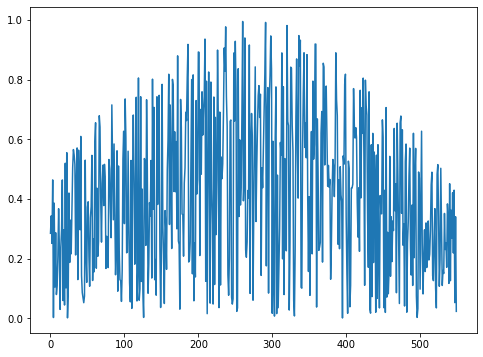

In [ ]:
def tapering(data, fac=3):
    n = data.shape[0]
    alpha = int(n/fac)
    left = np.cos(np.linspace(-np.pi/2,0,alpha))**2
    right = np.cos(np.linspace(0,np.pi/2,alpha))**2
    tapering_array = np.ones(n)
    tapering_array[:alpha] = left
    tapering_array[n-alpha:] = right
    return tapering_array*data

plt.plot(tapering(np.random.random(550), 5))

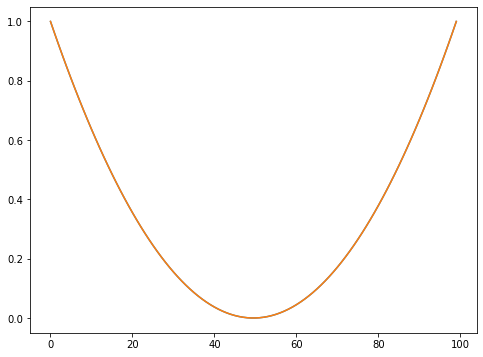

In [ ]:

def make_periodic(data):
    x_new = data.copy()
    x_new[np.where(x>0)] = x_new[np.where(x>0)]%np.pi
    x_new[np.where(x<0)] = x_new[np.where(x<0)]%-np.pi
    return x_new
x = 0.01*np.linspace(-10,10,100)**2


x_new = make_periodic(x)

plt.plot(x)
plt.plot(x_new)

In [ ]:
def get_glass_insertion(steps, stepsize, angle=4):
    angle_in_rad = np.pi*angle/180
    length_per_step = stepsize * np.tan(angle_in_rad)
    return np.linspace(-steps*length_per_step, steps*length_per_step, steps)

glass_stepsize = 0.51e-3 # [m]
glass_steps = 141
glass_insertion = get_glass_insertion(glass_steps, glass_stepsize) 
print(glass_insertion)


[-5.02843705e-03 -4.95660223e-03 -4.88476742e-03 -4.81293260e-03
 -4.74109779e-03 -4.66926297e-03 -4.59742816e-03 -4.52559334e-03
 -4.45375853e-03 -4.38192371e-03 -4.31008890e-03 -4.23825408e-03
 -4.16641927e-03 -4.09458445e-03 -4.02274964e-03 -3.95091482e-03
 -3.87908001e-03 -3.80724519e-03 -3.73541038e-03 -3.66357556e-03
 -3.59174075e-03 -3.51990593e-03 -3.44807112e-03 -3.37623630e-03
 -3.30440149e-03 -3.23256667e-03 -3.16073186e-03 -3.08889704e-03
 -3.01706223e-03 -2.94522741e-03 -2.87339260e-03 -2.80155778e-03
 -2.72972297e-03 -2.65788815e-03 -2.58605334e-03 -2.51421852e-03
 -2.44238371e-03 -2.37054889e-03 -2.29871408e-03 -2.22687926e-03
 -2.15504445e-03 -2.08320963e-03 -2.01137482e-03 -1.93954000e-03
 -1.86770519e-03 -1.79587037e-03 -1.72403556e-03 -1.65220074e-03
 -1.58036593e-03 -1.50853111e-03 -1.43669630e-03 -1.36486148e-03
 -1.29302667e-03 -1.22119185e-03 -1.14935704e-03 -1.07752222e-03
 -1.00568741e-03 -9.33852594e-04 -8.62017779e-04 -7.90182965e-04
 -7.18348150e-04 -6.46513

[3.84986000e-07 3.85264109e-07 3.85542217e-07 ... 1.09610978e-06
 1.09638789e-06 1.09666600e-06]
(4096,)
1717616455063668.8 4892779392780135.0


C:\Users\max-r\AppData\Local\Temp\ipykernel_4264\1710002816.py:8: RuntimeWarning: divide by zero encountered in true_divide
  l_nonlin = (2*np.pi*c)/w


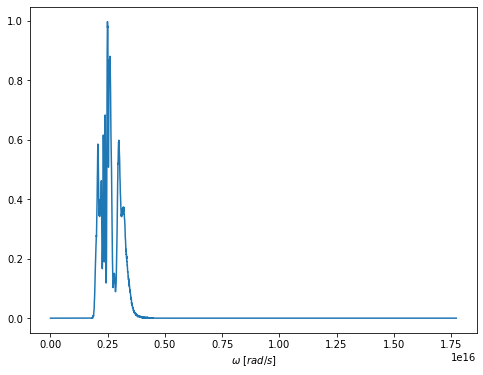

C:\Users\max-r\AppData\Local\Temp\ipykernel_4264\1710002816.py:26: RuntimeWarning: invalid value encountered in sqrt
  signal = fft.fftshift(fft.ifft(np.nan_to_num(np.sqrt(fund))))


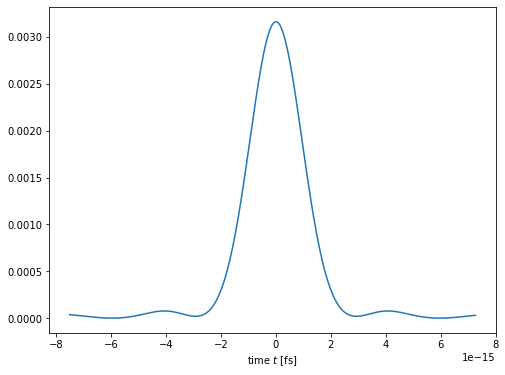

In [ ]:
print(wavelengths_data)

w_data = (2*np.pi*c)/wavelengths_data
fundamental_fkt = interp1d(w_data, tapering(fundamental_data, fac=5), kind="cubic")

w = np.linspace(0, delta_w*64, 2**12)
print(w.shape)
l_nonlin = (2*np.pi*c)/w

w_start = np.argwhere(w >= w_data[-1])[0,0]
w_end = np.argwhere(w <= w_data[0])[-1,0]
print(w_data[-1], w_data[0])
fund = np.zeros(2**12)
fund[w_start:w_end] = fundamental_fkt(w[w_start:w_end])
plt.plot(w, fund)
plt.xlabel("$\omega$ $[rad/s]$")
plt.show()

n = len(w)
w_s = np.sqrt(2)*64*delta_w/2**12
timestep = w_s/(2*np.pi)

t_1 = fft.fftfreq(n, d = timestep)
t = fft.fftshift(t_1)

signal = fft.fftshift(fft.ifft(np.nan_to_num(np.sqrt(fund))))

pm = 30
n = int(len(signal)/2)

signal_fkt = interp1d(t[n-pm:n+pm], (np.abs(signal)**2)[n-pm:n+pm], kind="cubic")
t_lin = np.linspace(t[n-pm:n+pm][0],t[n-pm:n+pm][-1],300)
plt.plot(t_lin, signal_fkt(t_lin))#t[n-pm:n+pm], (np.abs(signal)**2)[n-pm:n+pm])
plt.xlabel("time $t$ [fs]")
plt.show()

$S(\omega,z)=\left|\int_{-\infty}^{\infty}\left(\int_{-\infty}^{\infty}E(\omega)\exp(-izk(\Omega)+i\Omega t)d\Omega\right)^2\exp(-i\omega t)d\omega\right|$

$E(\omega)=|E(\omega)|\exp(i\phi(\omega))$

In [ ]:
def dispersion(lamb):
    lamb = lamb*1e6 # from [m] to [µm]
    n_sq =(0.6961663*lamb**2)/(lamb**2-0.06840432)+(0.4079426*lamb**2)/(lamb**2-0.11624142)+(0.8974794*lamb**2)/(lamb**2-9.8961612)
    n = np.sqrt(n_sq+1)
    return np.nan_to_num(n)

def phase(values, w_data, w_lin):
    samples = np.linspace(w_data[0], w_data[-1], values.size)
    fun = interp1d(samples, values, kind="cubic")
    
    w_start = np.argwhere(w_lin >= w_data[-1])[0,0]
    w_end = np.argwhere(w_lin <= w_data[0])[-1,0]
    #print(w_data[-1], w_data[0])


    phi_omega = np.zeros(2**12)
    phi_omega[w_start:w_end] = tapering(fun(w_lin[w_start:w_end]), 1)
    return phi_omega

#plt.plot(w, phase(np.random.random(50)-0.5, w_data, w))  
#plt.show()



def shg_signal(E_omega, w_lin, phase_omega, glass_insertion):
    n_omega = np.flip(dispersion(l_nonlin))
    k_omega = n_omega*w_lin/c
    
    phi = np.exp(1j*(phase_omega + glass_insertion * k_omega)) 
    E_omega_tilde = E_omega * phi

    E_t = fft.fft(E_omega_tilde, workers=8)
    shg_t = E_t**2
    shg_power_omega = np.abs(fft.ifft(shg_t, workers=8))**2
    return shg_power_omega

phi = phase(np.random.random(10)*10, w_data, w)
dscan = np.zeros((glass_insertion.shape[0], fund.shape[0])) 
E = np.nan_to_num(np.sqrt(fund))
#E_matrix = np.tile(E, (glass_insertion.shape[0], 1))
glass_matrix = np.tile(glass_insertion, (E.shape[0], 1)).T
#phase_matrix = np.tile(phi, (glass_insertion.shape[0], 1))

def dscan(values, glass_insertion):

    dscan = shg_signal(E, w, phi, glass_matrix)
    return dscan, phi

#plt.plot(w_data, dispersion(wavelengths_data)*w_data/c)
#plt.show()
%timeit trace, phase = dscan(np.random.random(10)*10, glass_insertion)
#trace, phase = dscan(np.random.random(10)*10, glass_insertion)
#plt.imshow(trace, aspect="auto", cmap="turbo")
#plt.plot(w, shg_signal(np.nan_to_num(np.sqrt(fund)), 0.005, w, l_nonlin, phase(np.random.random(50)-0.5, w_data, w)))

C:\Users\max-r\AppData\Local\Temp\ipykernel_4264\3074890330.py:39: RuntimeWarning: invalid value encountered in sqrt
  E = np.nan_to_num(np.sqrt(fund))
C:\Users\max-r\AppData\Local\Temp\ipykernel_4264\3074890330.py:3: RuntimeWarning: invalid value encountered in true_divide
  n_sq =(0.6961663*lamb**2)/(lamb**2-0.06840432)+(0.4079426*lamb**2)/(lamb**2-0.11624142)+(0.8974794*lamb**2)/(lamb**2-9.8961612)
C:\Users\max-r\AppData\Local\Temp\ipykernel_4264\3074890330.py:4: RuntimeWarning: invalid value encountered in sqrt
  n = np.sqrt(n_sq+1)


105 ms ± 22.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [3]:
values = np.linspace(-1,1,30)**3#values = (np.random.random(30)-0.5)*10

simulated_trace, phi = dscan(values, glass_insertion)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].plot(w, fund)
ax[1].imshow(simulated_trace, extent=[w[0], w[-1], glass_insertion[0], glass_insertion[-1]], aspect="auto", cmap="turbo")
ax2 = ax[0].twinx()
ax2.plot(w, phi, "--", color="black", alpha=0.8)

NameError: name 'dscan' is not defined

(141, 2560)
1.7733662210983664e+16 5689140211022946.0


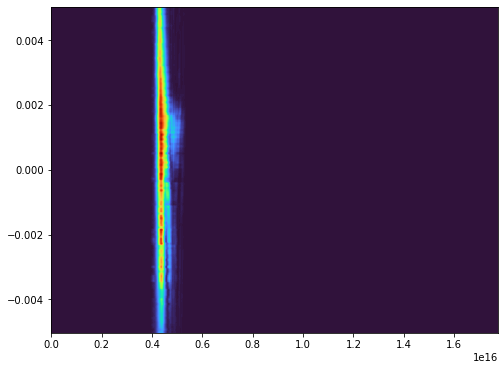

In [15]:
real_trace = pd.read_table("../Data/test-data/Trace.txt", delimiter=" ", decimal=",").values
print(real_trace.shape)

def resample_trace(trace, w_shg_data):
    w = np.linspace(0, delta_w*64, 2**12)
    
    w_start = np.argwhere(w >= w_shg_data[-1])[0,0]
    w_end = np.argwhere(w <= w_shg_data[0])[-1,0]
    print(max(w), max(w_shg_data))

    resampled_trace = []
    for spectrum in trace:
        spec = np.zeros(2**12) 
        spectrum_omega_fkt = interp1d(w_shg_data, tapering(spectrum, fac=5), kind="cubic")
        spectrum_omega = spectrum_omega_fkt(w[w_start:w_end])
        spec[w_start:w_end] = spectrum_omega
        resampled_trace.append(spec)
    return np.array(resampled_trace)/np.max(resampled_trace)

plt.imshow(resample_trace(real_trace, (2*np.pi*c)/lin_shg), extent=[w[0], w[-1], glass_insertion[0], glass_insertion[-1]], aspect="auto", cmap="turbo")

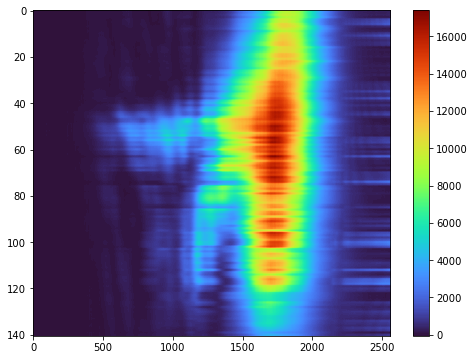

In [21]:
plt.imshow(real_trace, aspect="auto", cmap="turbo")
plt.colorbar()

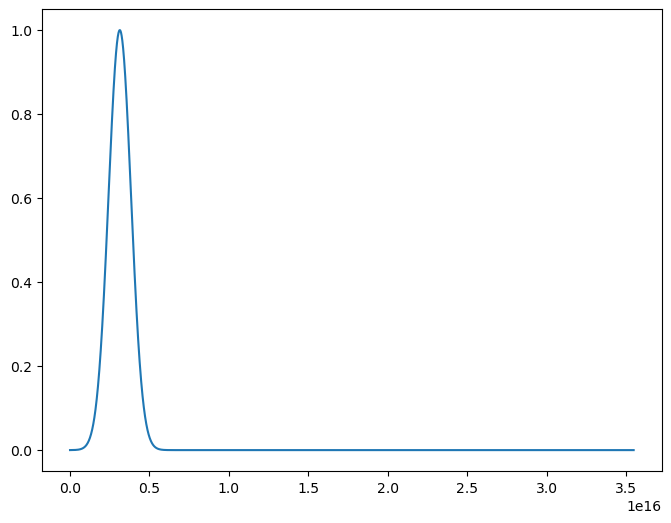

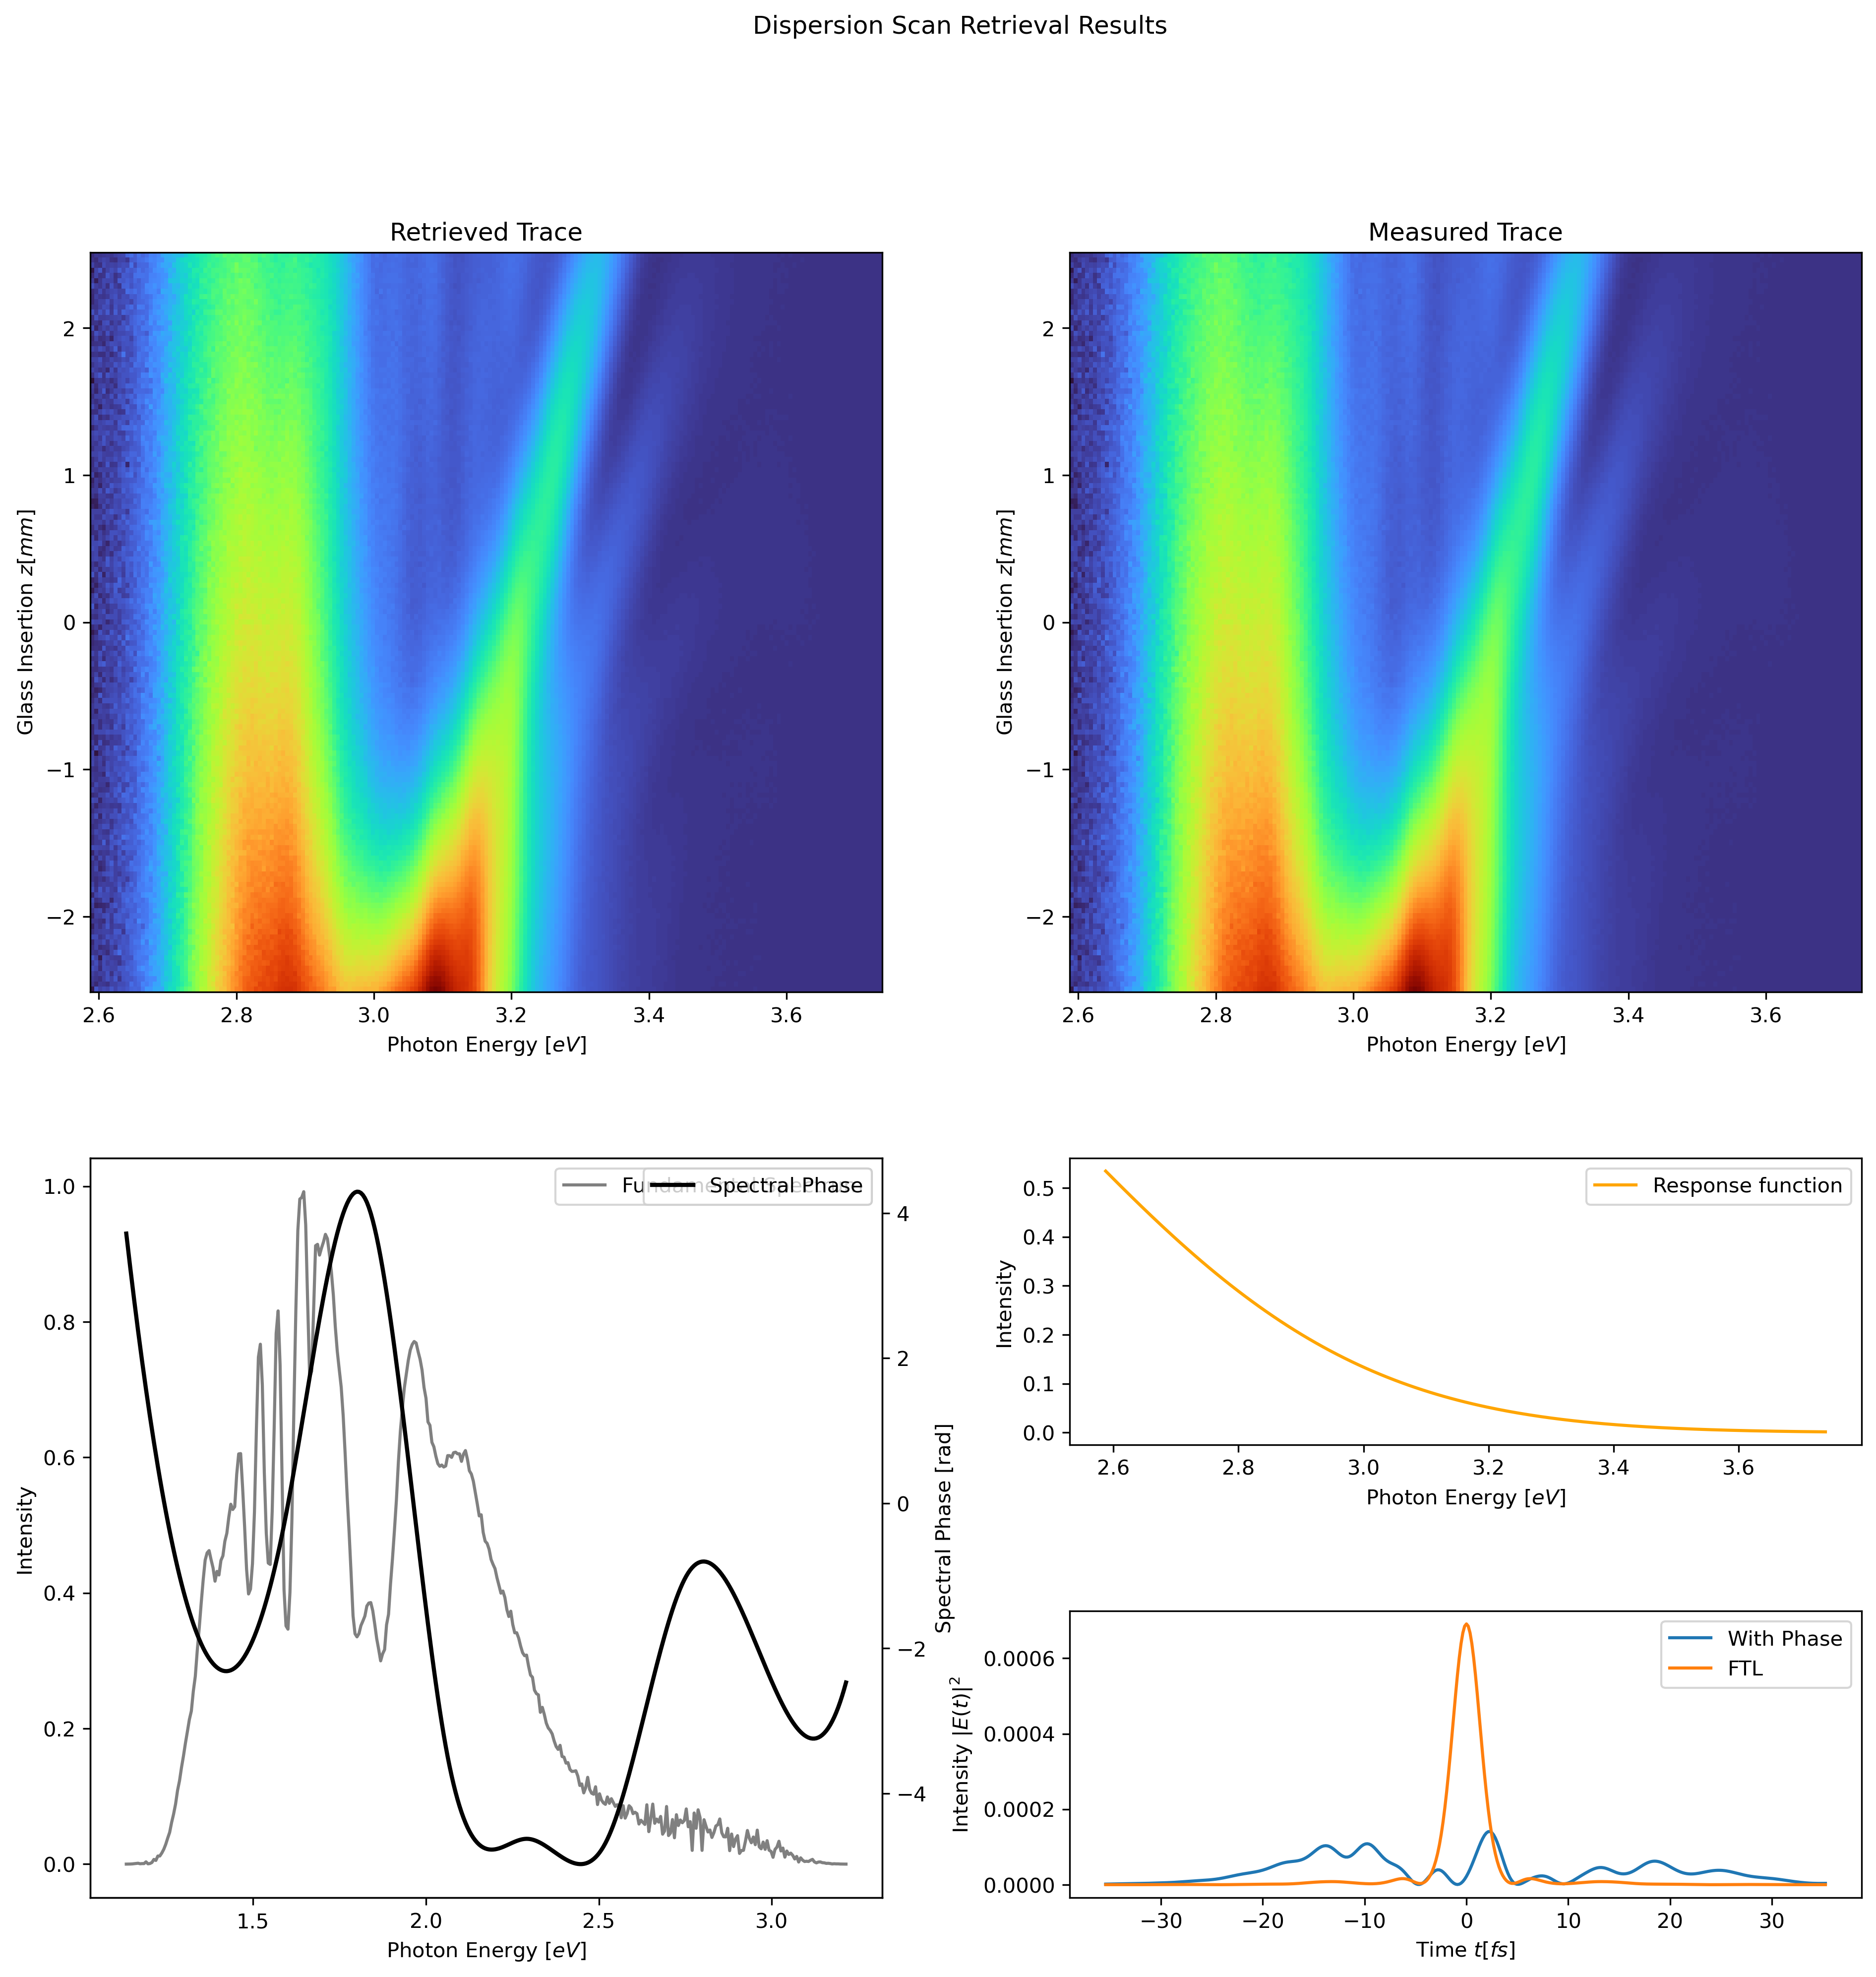

True


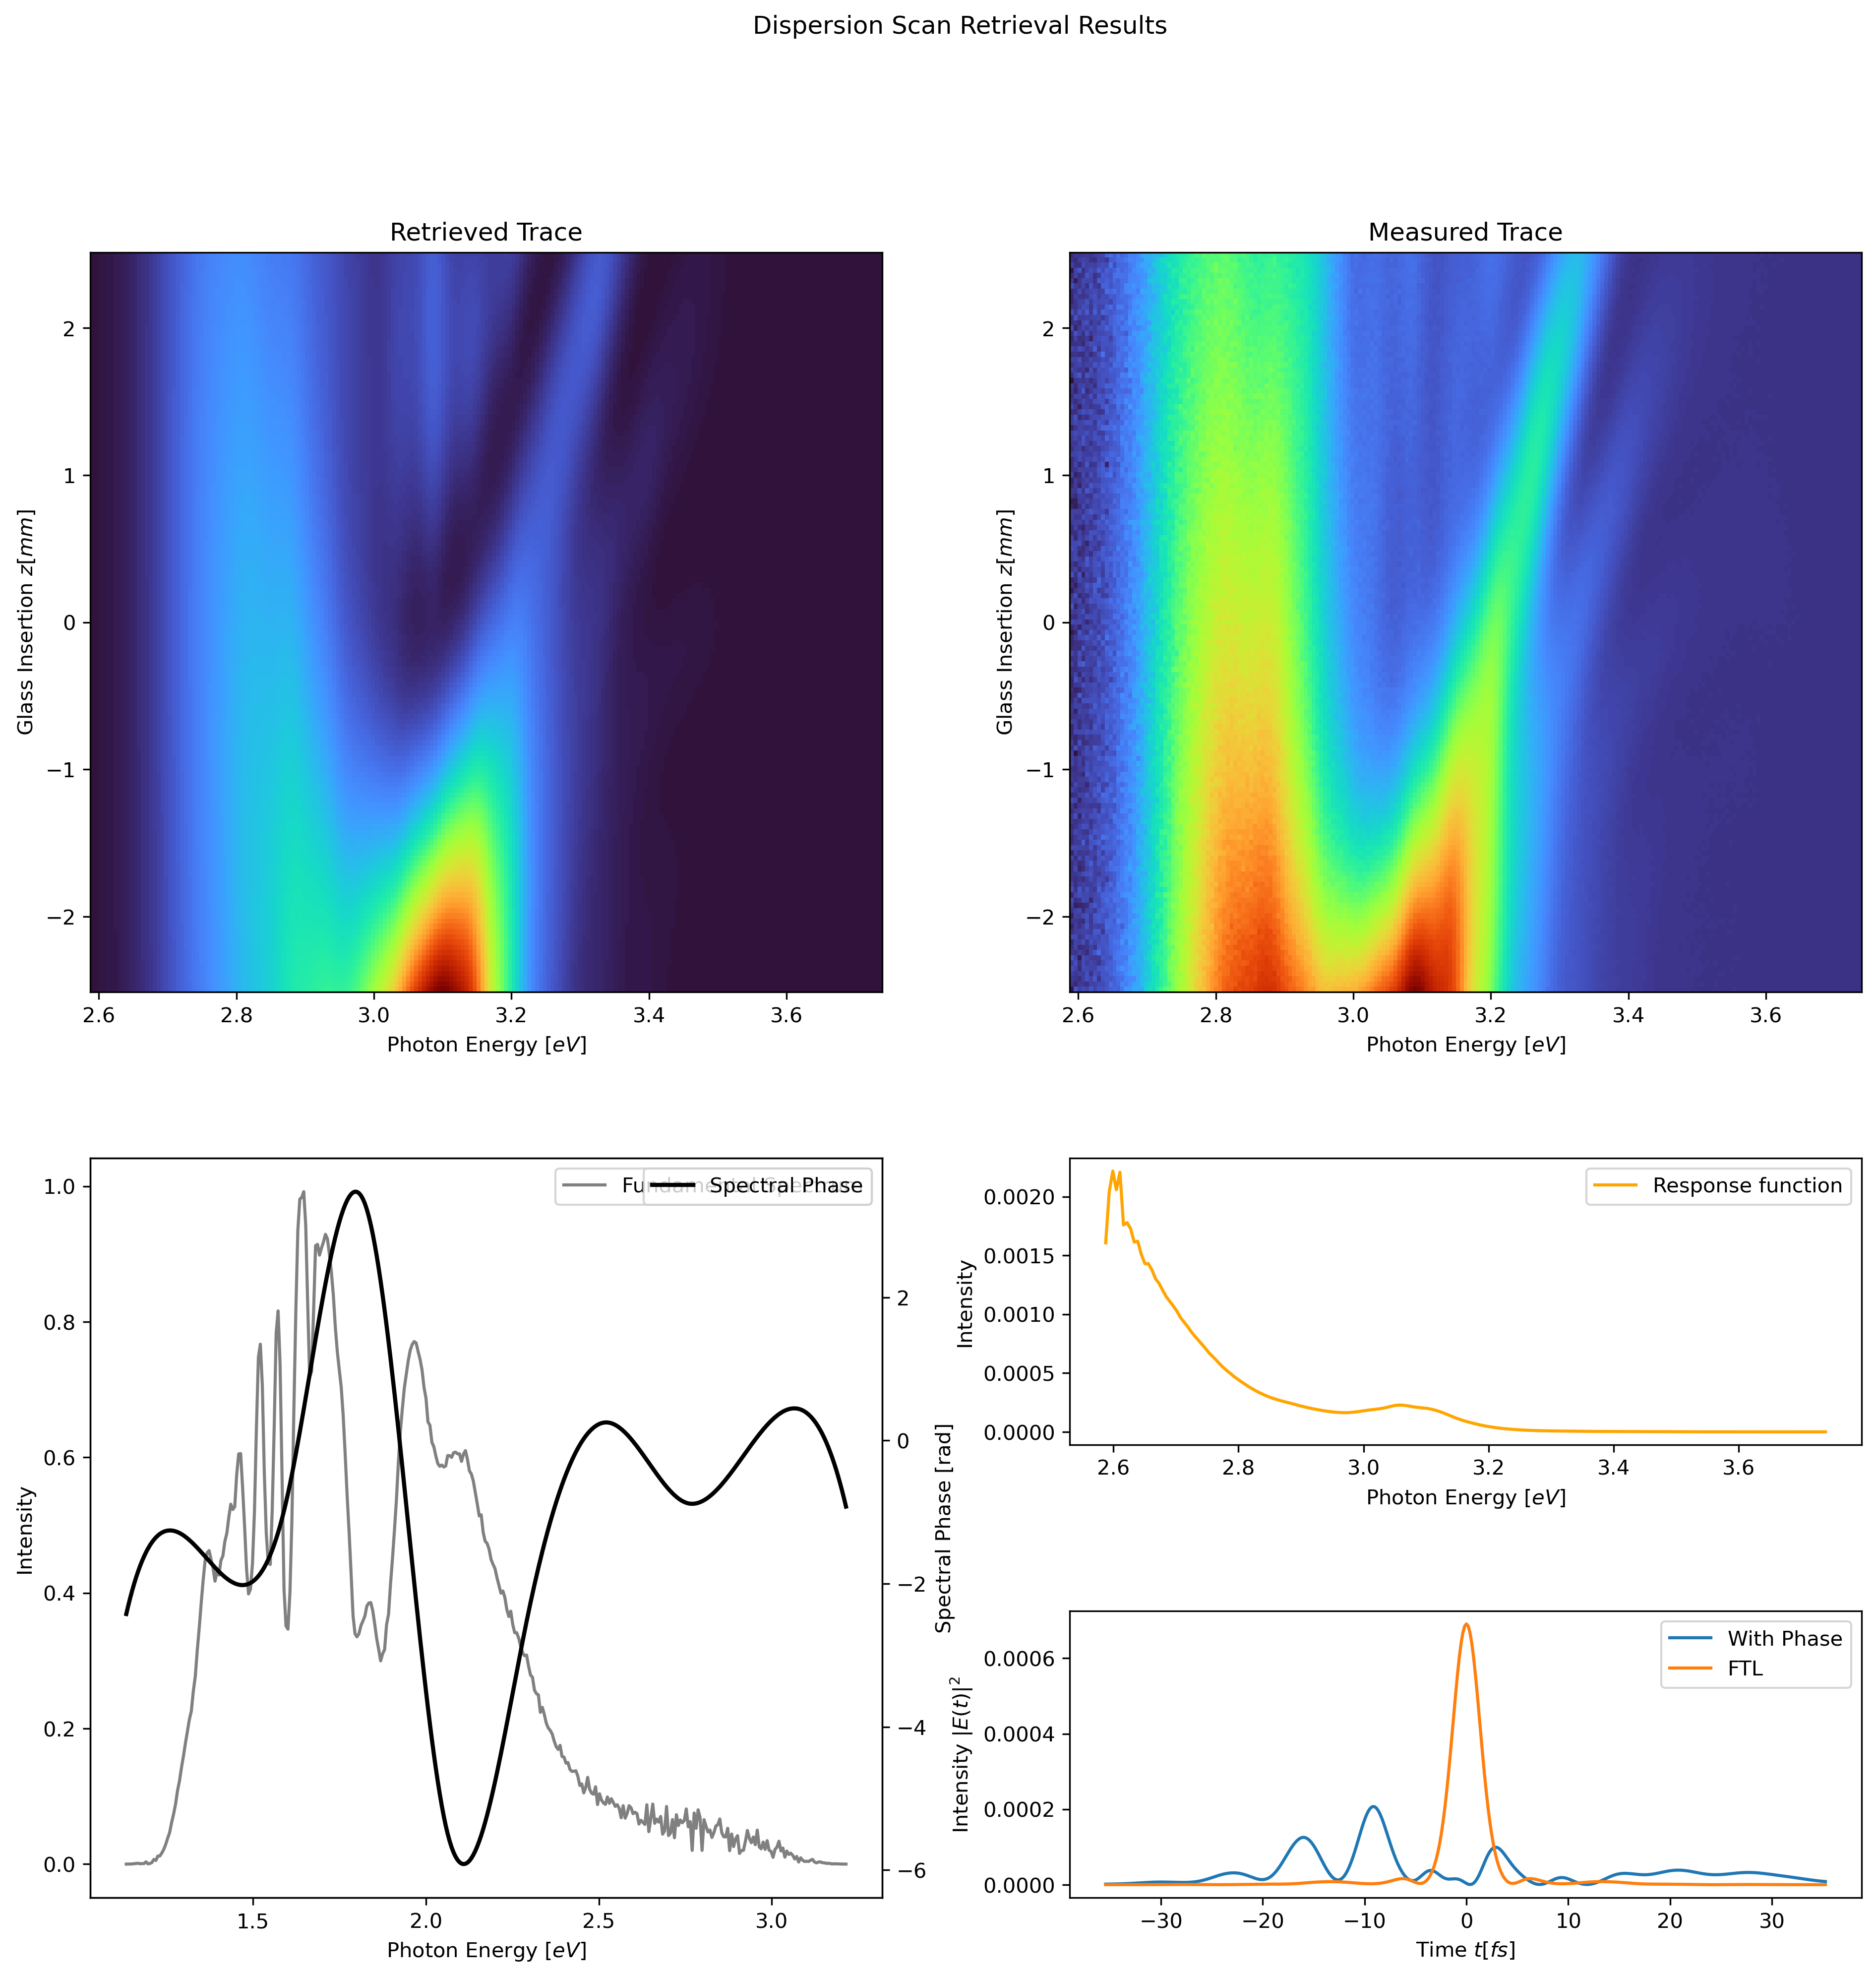

In [2]:
from dscan_retrieval import *

dscan = Dscan("/home/max/Dropbox/MPI/Data/test-data/Fundamental.txt")
#dscan = Dscan("C:\\Users\max-r\\Dropbox\\MPI\\Data\\test-data\\Fundamental.txt")

values = (np.random.random(10)-0.5)*10#np.linspace(-1,1,10)*10#0.06*np.arange(-10,10)**2#(np.random.random(10)-0.5)*10
x = dscan.omega_lin
x0 = (2*np.pi*c)/ 600e-9
sigma = 10e14
response = np.exp(-(x-x0)**2/sigma**2)

plt.plot(x, response)
plt.show()

noise = np.random.normal(0,1,())

trace = dscan.simulate_trace(values)*response 
noise = np.random.normal(0,1e-4,trace.shape)
trace += noise

dscan.plot_result(trace, trace, values, response)

params = 10
lb = 0.0001
retrieved_phase, retrieved_trace = dscan.retrieval(trace, params=params, lb=lb)

dscan.plot_result()

True


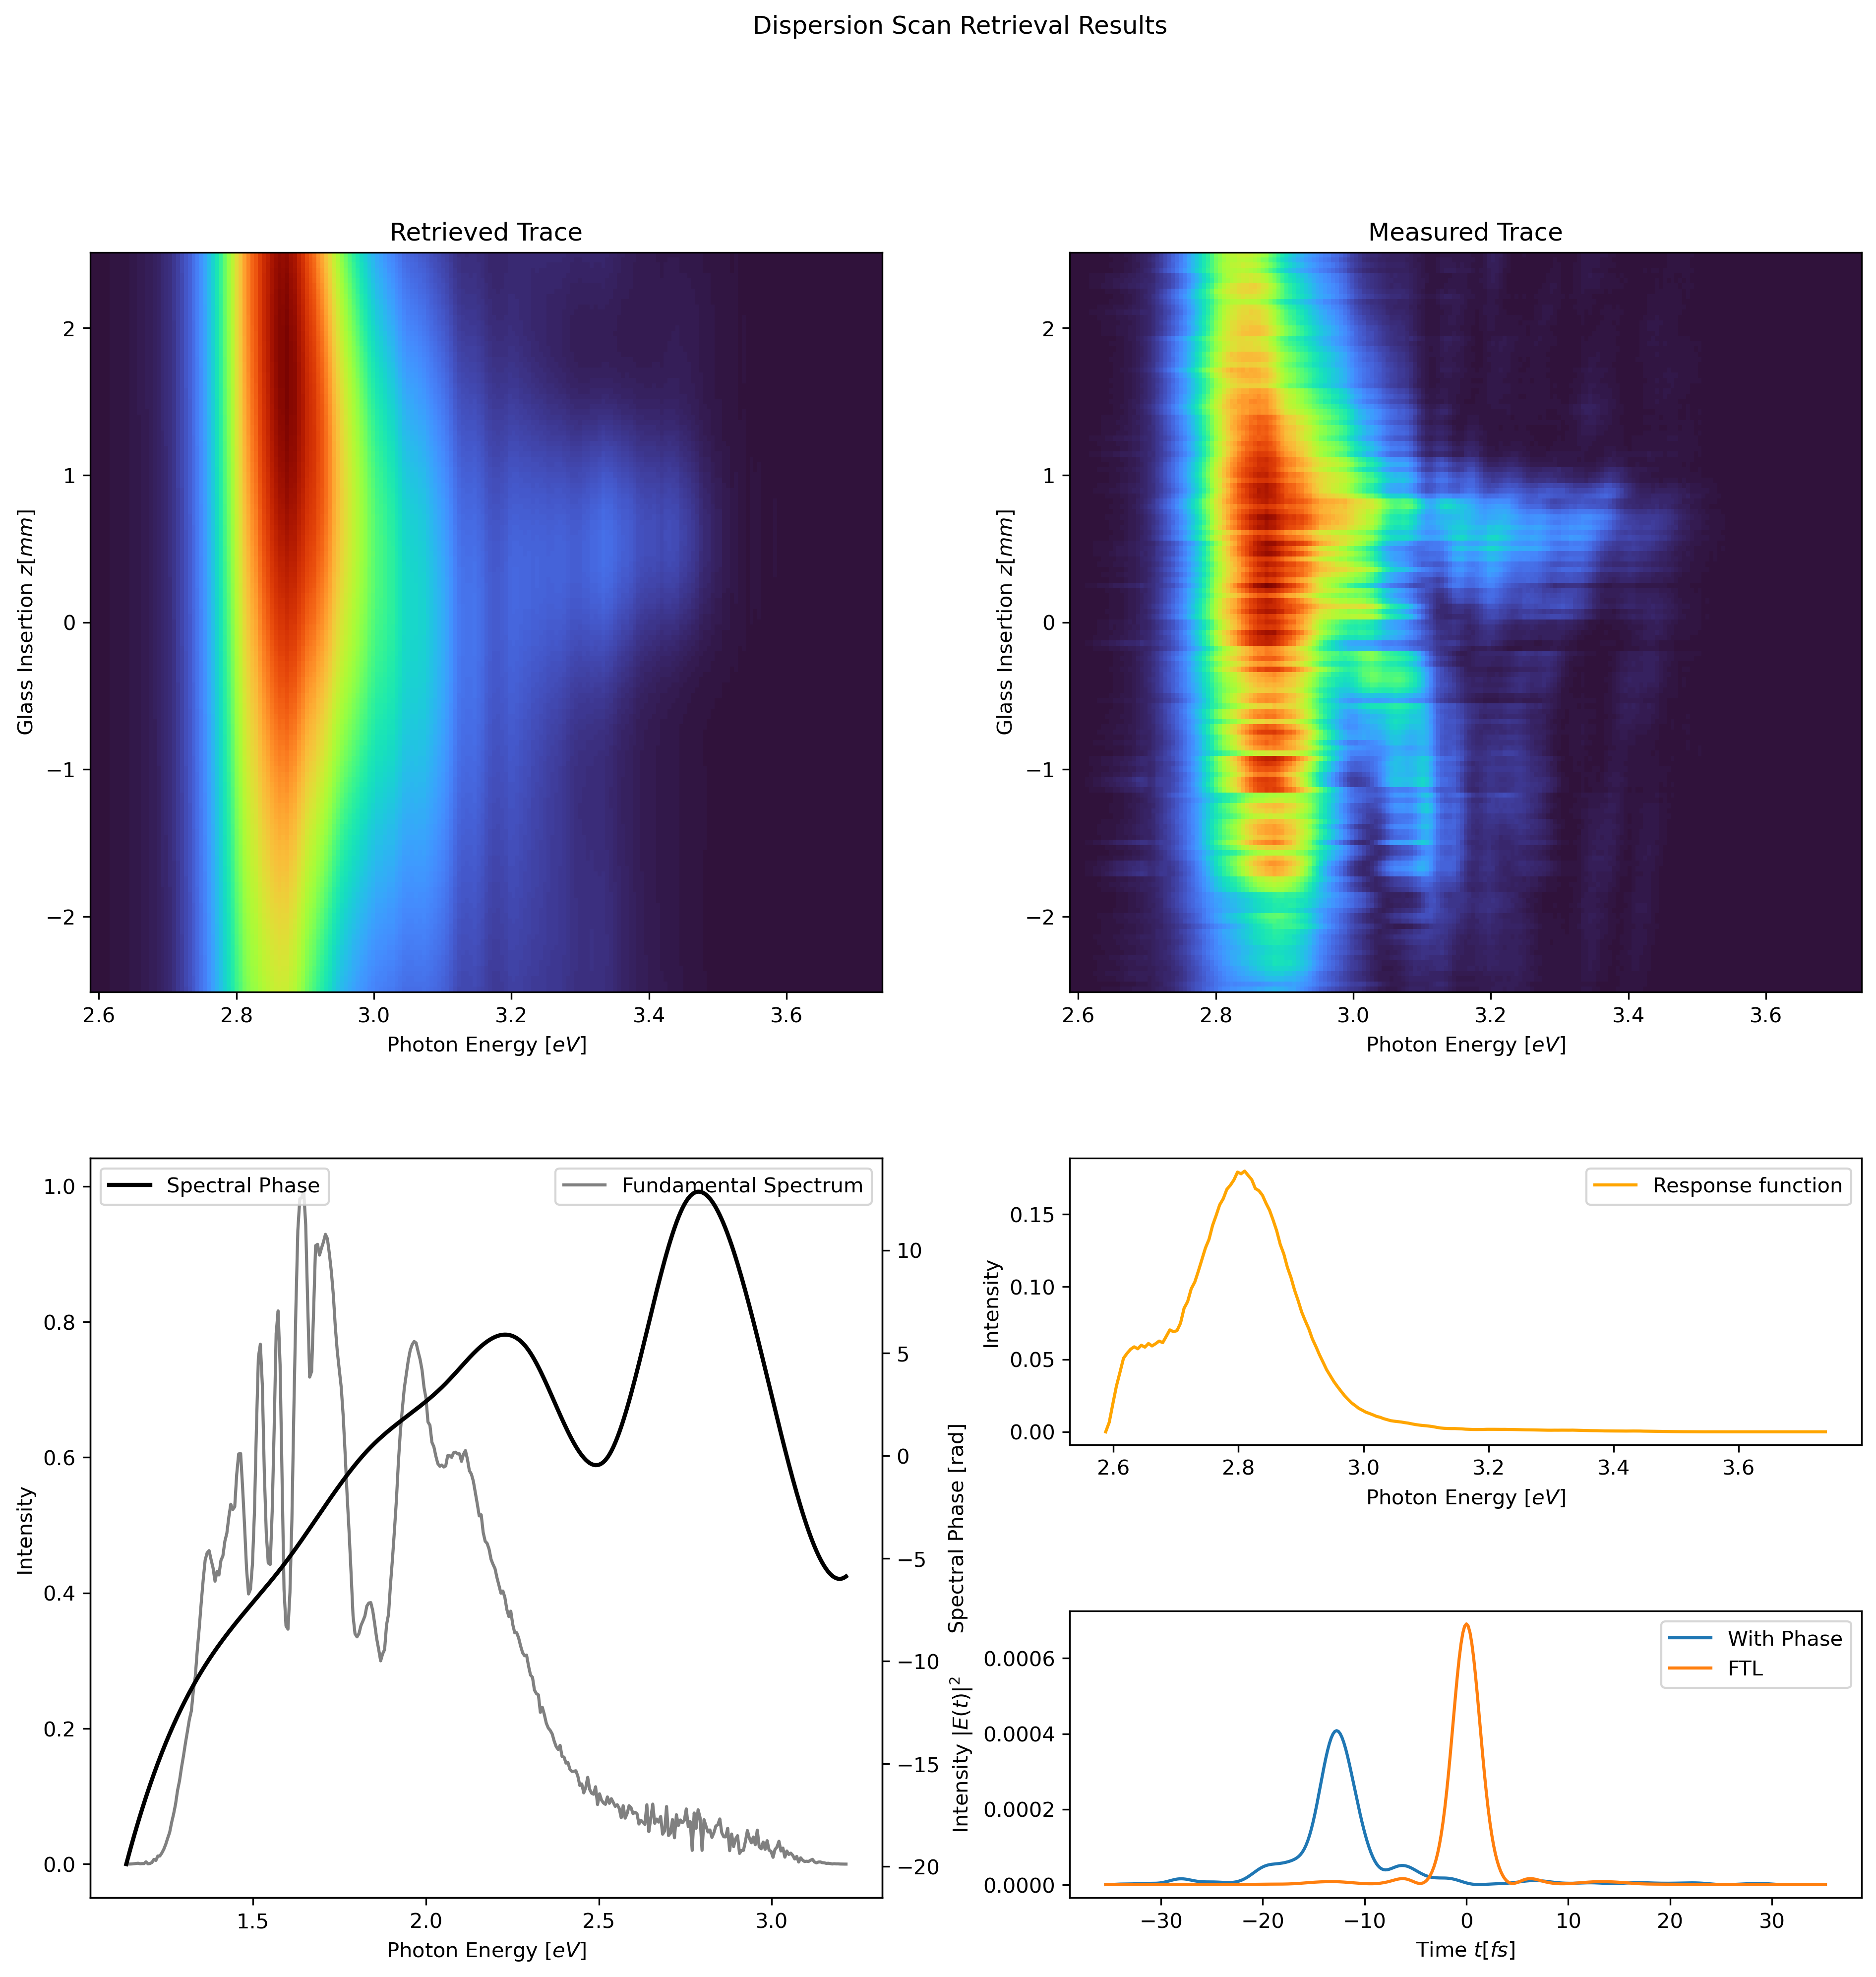

In [1]:
from dscan_retrieval import *

dscan = Dscan("/home/max/Dropbox/MPI/Data/test-data/Fundamental.txt")
#dscan = Dscan("C:\\Users\max-r\\Dropbox\\MPI\\Data\\test-data\\Fundamental.txt")

real_trace = pd.read_table("/home/max/Dropbox/MPI/Data/test-data/Trace.txt", delimiter=" ", decimal=",").values
resampled_trace = dscan.resample_trace(real_trace)

params = 10
lb = 0.0001

retrieved_phase, retrieved_trace = dscan.retrieval(resampled_trace, params=params, lb=lb)

dscan.plot_result()